In [1]:
import numpy as np 

In [101]:
def sphere_to_cart(r, theta, phi):
    z = r * np.cos(theta) 
    xy = r * np.sin(theta)
    x = xy * np.cos(phi)
    y = xy * np.sin(phi)
    return x, y, z

def cart_to_sphere(x, y, z):
    xy = x**2 + y**2
    R = np.asarray(np.sqrt(xy + z**2))
    theta = np.asarray(np.arccos(z / R))
    phi = np.asarray(np.arctan2(y, x))
    phi[phi < 0] = phi[phi < 0] + np.pi * 2
    return R, theta, phi

def bbox_from_range(r, theta, phi):
    xyz = sphere_to_cart(r, theta, phi)
    bbox_cart = []
    for idim in range(3):
        bbox_cart.append([np.min(xyz[idim]), np.max(xyz[idim])])
    bbox_cart = np.array(bbox_cart)

    return bbox_cart


def get_cart_bbox(bbox_spherical, 
                  n_test_points = 100, 
                  expand_frac = 0.001, 
                  round_box=True, 
                 override_to_full_range=False):
    # bbox_spherical, ordered as (r, theta, phi), theta = colat angle, phi = polar 0 to 2pi angle    
    
    r_min = bbox_spherical[0,0]
    r_max = bbox_spherical[0,1]

    angular_bounds = np.array([[0, np.pi], [0, 2 * np.pi]])
    
    if np.allclose(bbox_spherical[1:,:], angular_bounds) or override_to_full_range:    
        bbox_cart = np.array([[-r_max, r_max], 
                             [-r_max, r_max], 
                             [-r_max, r_max], ])
        return bbox_cart    
    
    
    theta_test = np.linspace(bbox_spherical[1][0], bbox_spherical[1][1], n_test_points)
    phi_test = np.linspace(bbox_spherical[2][0], bbox_spherical[2][1], n_test_points)
    
    theta_test, phi_test = np.meshgrid(theta_test, phi_test)
    
    bbox_1 = bbox_from_range(r_min, theta_test, phi_test)    
    bbox_2 = bbox_from_range(r_max, theta_test, phi_test)
    
    bbox_cart = np.zeros((3,2))
    bbox_cart[:, 0] = np.min([bbox_1[:, 0], bbox_2[:,0]], axis=0)
    bbox_cart[:, 1] = np.max([bbox_1[:, 1], bbox_2[:,1]], axis=0)

    bbox_cart[:, 0] = bbox_cart[:, 0] * (1. + expand_frac)
    bbox_cart[:, 1] = bbox_cart[:, 1] * (1. + expand_frac)
    if round_box:
        bbox_cart = np.round(bbox_cart)
    return bbox_cart


def get_grid_edges_by_dim(le, grid_wids, starting_n_grids):
    left_edges_by_dim = []
    right_edges_by_dim = []
    for idim in range(3):    
        edges = le[idim] + grid_wids[idim] * (np.cumsum(np.ones((starting_n_grids[idim]+1,))) - 1)
        left_edges = edges[0:-1]
        right_edges = edges[1:]
        left_edges_by_dim.append(left_edges)
        right_edges_by_dim.append(right_edges)
    return left_edges_by_dim, right_edges_by_dim
    

def decompose_level_0(bbox_cart,
                      bbox_spherical,
                      starting_dims,
                      starting_n_grids,):

    ndim = 3
    if isinstance(starting_dims, int):
        starting_dims = np.array([starting_dims,]*ndim, dtype=int)

    if isinstance(starting_n_grids, int):
        starting_n_grids = np.array([starting_n_grids,]*ndim, dtype=int)
        
    re_cart = bbox_cart[:,1]
    le_cart = bbox_cart[:,0]
    domain_width = re_cart - le_cart # domain_width
    dxyz = domain_width / starting_dims

    n_per_grid = starting_dims / starting_n_grids  # nodes per coarse grid
    grid_wids = n_per_grid * dxyz  # grid widths

    les_by_dim, res_by_dim = get_grid_edges_by_dim(le_cart, grid_wids, starting_n_grids)
    nodes_by_dim = [np.full((starting_n_grids[idim]),n_per_grid[idim], dtype=int) for idim in range(3)]


    left_edges = by_dims_to_grid_list(les_by_dim)
    right_edges = by_dims_to_grid_list(res_by_dim)
    grid_shapes = by_dims_to_grid_list(nodes_by_dim)
    
    grid_list = []
    for igrid in range(len(left_edges)):
        grid_dict = {
            'left_edge': left_edges[igrid], 
            'right_edge': right_edges[igrid],             
            "level": 0,
            "dimensions": grid_shapes[igrid],
        }
        grid_list.append(grid_dict)

    return grid_list, list(starting_dims)

def by_dims_to_grid_list(list_by_dim):
    point_combos = np.meshgrid(*list_by_dim, indexing='ij')
    return np.column_stack([le.ravel() for le in point_combos])


In [102]:
bbox_spherical = np.array([[5000, 6371], 
                           [0, np.pi], 
                           [0, 2*np.pi]])
bbox_cart = get_cart_bbox(bbox_spherical)
grids, starting_dims = decompose_level_0(bbox_cart, bbox_spherical, 24, 3)

In [103]:
grids[1].copy()

{'left_edge': array([-6371.        , -6371.        , -2123.66666667]),
 'right_edge': array([-2123.66666667, -2123.66666667,  2123.66666667]),
 'level': 0,
 'dimensions': array([8, 8, 8])}

In [104]:
lev_1 = grids[1].copy()
wid = lev_1['right_edge'] - lev_1['left_edge']
dxyz = wid / lev_1['dimensions']

lev_1['left_edge'] = lev_1['left_edge'] + dxyz*2.
lev_1['right_edge'] = lev_1['right_edge'] - dxyz*2
lev_1['level'] = 1
grids.append(lev_1)
lev_1

{'left_edge': array([-5309.16666667, -5309.16666667, -1061.83333333]),
 'right_edge': array([-3185.5       , -3185.5       ,  1061.83333333]),
 'level': 1,
 'dimensions': array([8, 8, 8])}

In [98]:
def _reader(grid ,field):

    x = grid.fcoords[:,0].reshape(grid.ActiveDimensions)
    y = grid.fcoords[:,1].reshape(grid.ActiveDimensions)
    z = grid.fcoords[:,2].reshape(grid.ActiveDimensions)

    r, theta, phi = cart_to_sphere(x, y, z)
    
    rmask = np.logical_and(r >= bbox_spherical[0,0], r <= bbox_spherical[0,1])
    thmask = np.logical_and(theta >= bbox_spherical[1,0], theta <= bbox_spherical[1,1])
    phmask = np.logical_and(phi >= bbox_spherical[2,0], phi <= bbox_spherical[2,1])
    mask = np.logical_and(rmask, thmask)
    mask = np.logical_and(mask, phmask)

    dens = np.zeros(x.shape)
    dens[mask] = 1.0
    return dens

In [99]:
for gid in range(len(grids)):    
    grids[gid]['field0'] = (_reader, '')

In [100]:
import yt 

ds = yt.load_amr_grids(grids, starting_dims, bbox=bbox_cart, length_unit='km')

YTIllDefinedAMR: Grids on the level 1 are not properly aligned with cell edges on the parent level ('z' axis)

yt : [INFO     ] 2024-02-02 15:47:13,839 xlim = -6371.000000 6371.000000
yt : [INFO     ] 2024-02-02 15:47:13,840 ylim = -6371.000000 6371.000000
yt : [INFO     ] 2024-02-02 15:47:13,842 xlim = -6371.000000 6371.000000
yt : [INFO     ] 2024-02-02 15:47:13,842 ylim = -6371.000000 6371.000000
yt : [INFO     ] 2024-02-02 15:47:13,843 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



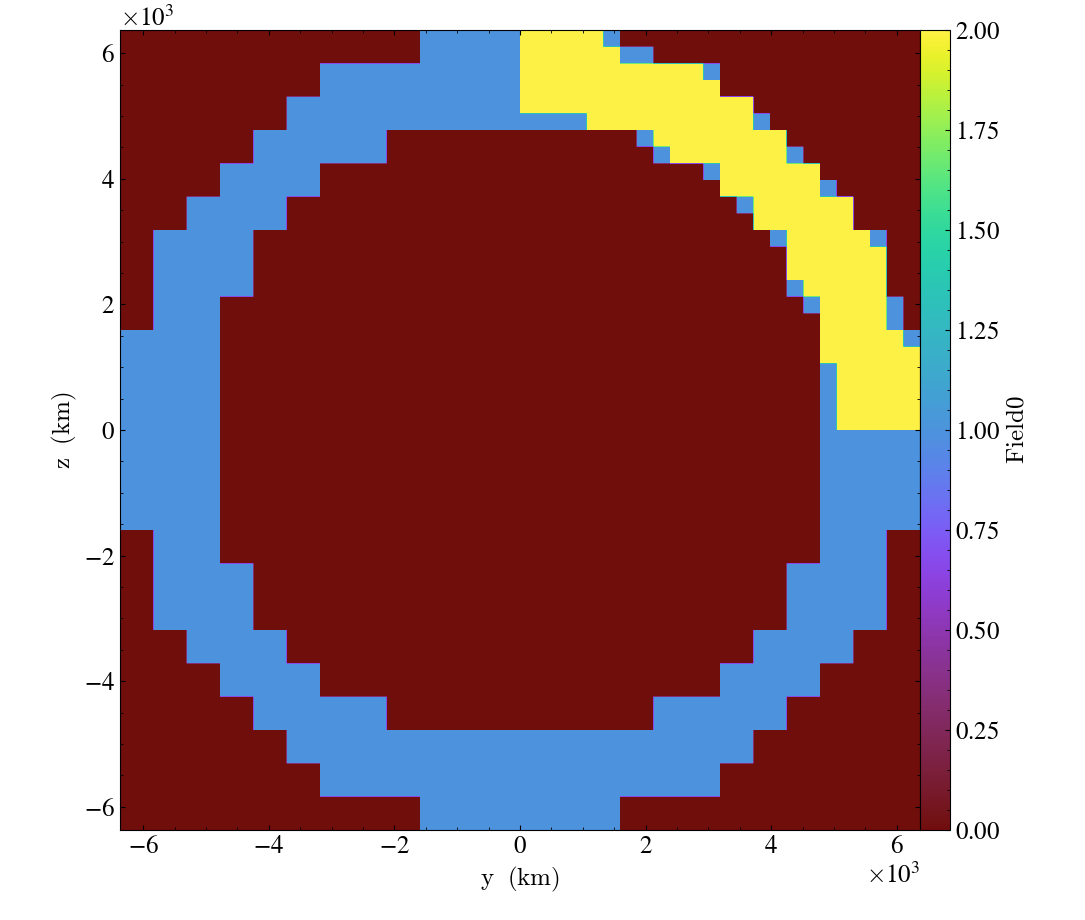

In [80]:
slc = yt.SlicePlot(ds, 'x', ('stream', 'field0'))
slc.set_log(('stream', 'field0'), False)
# slc.annotate_grids()

In [97]:
g = ds.index.grids[0]


In [100]:
g.ActiveDimensions

array([8, 8, 8], dtype=int32)

In [73]:
16*16*16

4096